In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
zip_file_path = '/content/drive/MyDrive/Datasets/kidney_refined_img'
csv_file_path = '/content/drive/MyDrive/Datasets/Coldsheet.csv'

Mounted at /content/drive


In [ ]:
scores_df = pd.read_csv(csv_file_path)
scores_df.head()

,Name of image,Score of 1 - 5
0,Cold Kidney 2,5
1,Cold Kidney 3,5
2,Cold Kidney 4,5
3,Cold Kidney 5,5
4,Cold Kidney 6,4


In [ ]:
def load_and_preprocess_image(image_path):
    if os.path.isfile(image_path):
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    return None

In [ ]:
image_dir = '/content/drive/MyDrive/Datasets/kidney_refined_img/images new'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, filename))]
image_arrays = [load_and_preprocess_image(path) for path in image_paths if load_and_preprocess_image(path) is not None]
image_arrays = np.vstack([img_array for img_array in image_arrays if img_array is not None])

def format_filename(name):
    return os.path.splitext(name)[0].lower().strip()

scores_df['formatted_name'] = scores_df['Name of image'].apply(format_filename)
name_to_score = dict(zip(scores_df['formatted_name'], scores_df['Score of 1 - 5']))

In [ ]:
scores = []
not_found = []

for path in image_paths:
    if os.path.isfile(path):
        base_name = format_filename(os.path.basename(path))
        score = name_to_score.get(base_name, None)
        if score is not None:
            scores.append(score)
        else:
            not_found.append(os.path.basename(path))
            scores.append(-1)

if not_found:
    print("No scores found for the following files:")
    for file in not_found:
        print(file)
else:
    print("All files matched successfully.")

All files matched successfully.


In [ ]:
scores = np.array(scores)
valid_indices = [i for i, score in enumerate(scores) if score != -1]
image_arrays = image_arrays[valid_indices]
scores = np.array([scores[i] for i in valid_indices])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_arrays, scores, test_size=0.2, random_state=42)
y_train_one_hot = to_categorical(y_train - 1, num_classes=5)
y_test_one_hot = to_categorical(y_test - 1, num_classes=5)

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, shuffle=True)

Epoch 1/10
3/3 [==============================] - 54s 15s/step - loss: 64.4458 - accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 49s 15s/step - loss: 25.7340 - accuracy: 0.6750
Epoch 3/10
3/3 [==============================] - 52s 15s/step - loss: 7.4583 - accuracy: 0.8500
Epoch 4/10
3/3 [==============================] - 48s 15s/step - loss: 3.2377 - accuracy: 0.9125
Epoch 5/10
3/3 [==============================] - 49s 15s/step - loss: 0.4670 - accuracy: 0.9875
Epoch 6/10
3/3 [==============================] - 52s 15s/step - loss: 0.0970 - accuracy: 0.9875
Epoch 7/10
3/3 [==============================] - 48s 15s/step - loss: 0.0032 - accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 48s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 51s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
3/3 [==============================] - 48s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 vgg16
1 flatten_1
2 dense_2
3 dense_3


In [ ]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue

In [ ]:
# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

dense_3 (512, 5)


In [ ]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

553467096/553467096 [==============================] - 10s 0us/step
block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


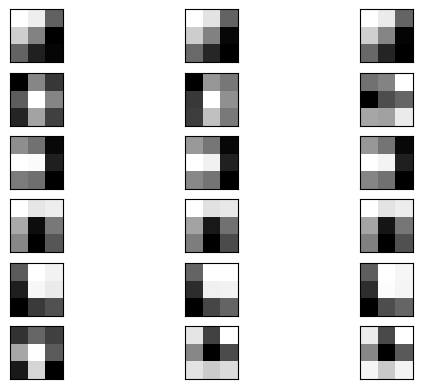

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
pyplot.show()

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

In [ ]:
vgg_base = model.get_layer('vgg16')

for i, layer in enumerate(vgg_base.layers):
    if 'conv' in layer.name:
        print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [ ]:
img = load_img('/content/drive/MyDrive/Datasets/kidney_refined_img/images new/Cold Kidney 30.jpg', target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)

1/1 [==============================] - 1s 797ms/step


In [ ]:
# Define the layers you're interested in
ixs = [2, 5, 9, 13, 17]
layers = [model.get_layer('vgg16').layers[i] for i in ixs]
outputs = [layer.output for layer in layers]

# Define the model inputs directly from the VGG16 layer within your custom model
model_vgg_input = model.get_layer('vgg16').input

# Redefine the model outputs using the VGG16 layer references
outputs = [model.get_layer('vgg16').layers[i].output for i in ixs]

# Create a new model that will return these outputs given the VGG16 inputs
feature_model = Model(inputs=model_vgg_input, outputs=outputs)

# Get feature maps
feature_maps = feature_model.predict(img)

1/1 [==============================] - 1s 897ms/step


1/1 [==============================] - 1s 1s/step


<ipython-input-29-ca57826d5921>:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(square, square, ix)


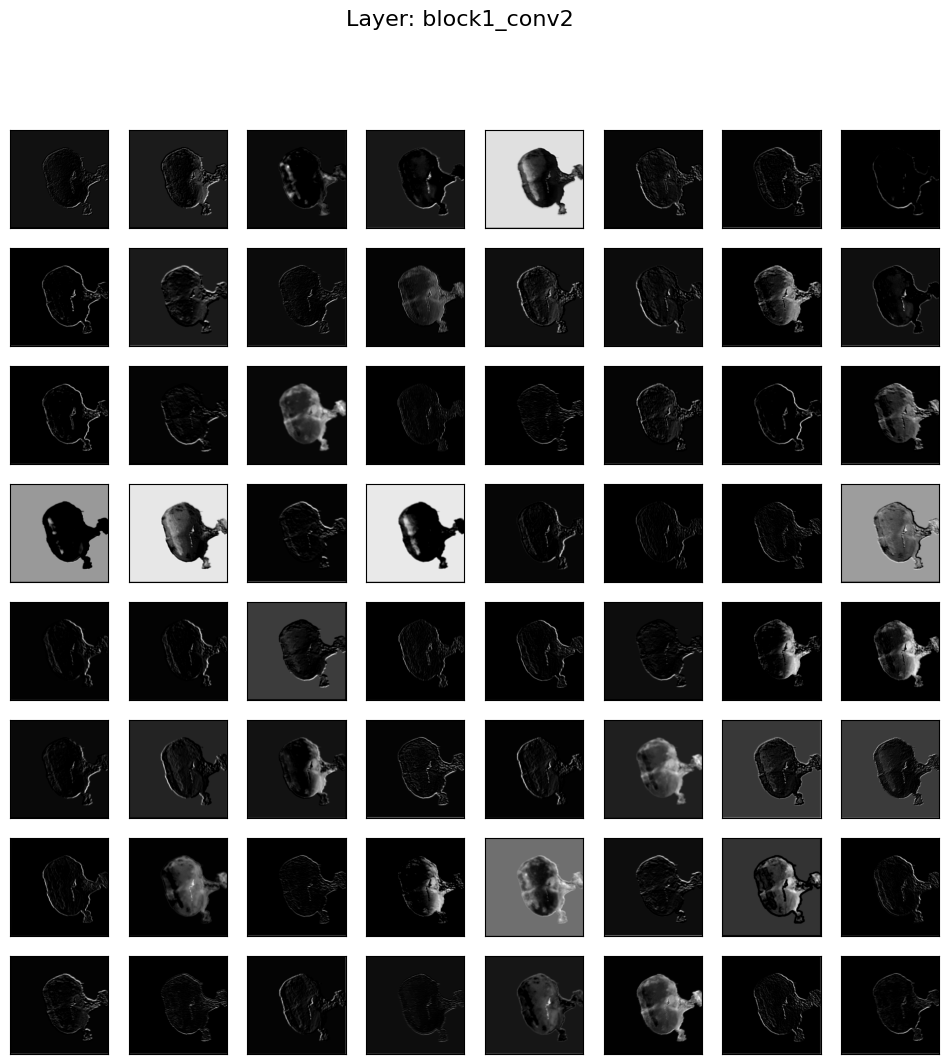

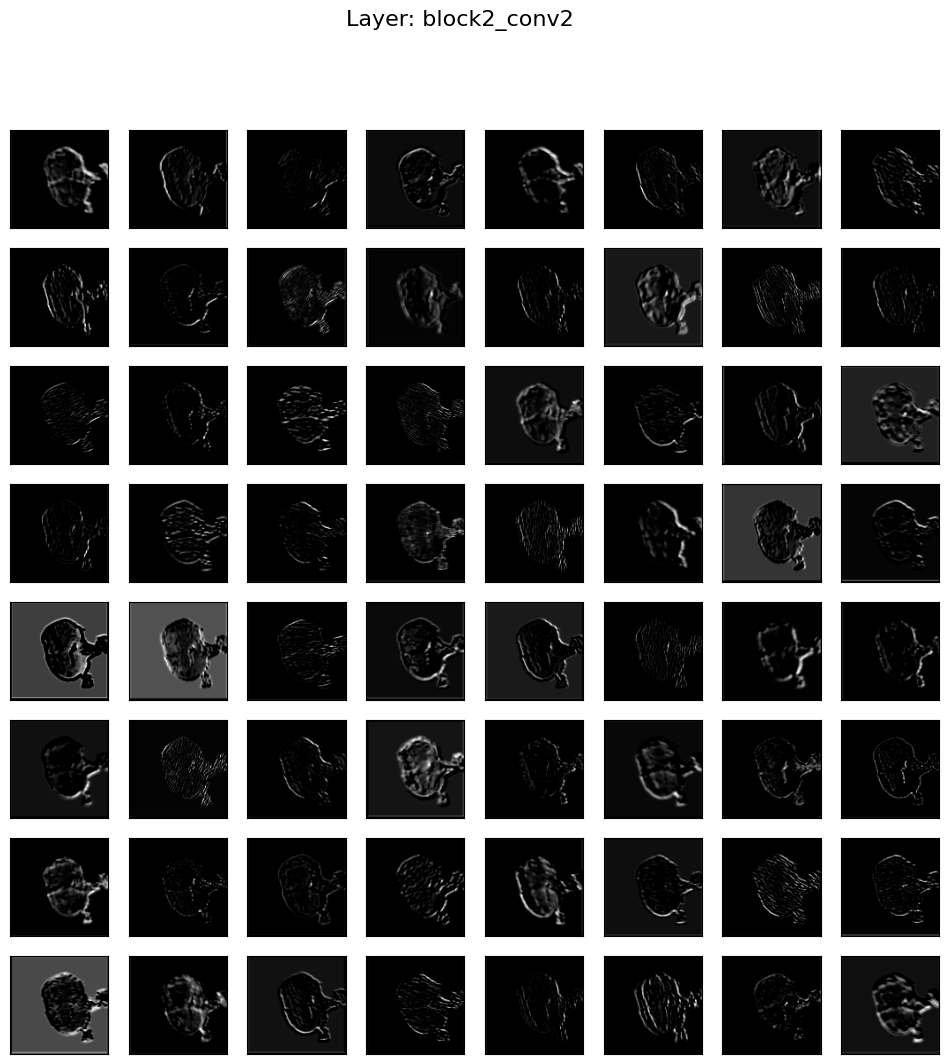

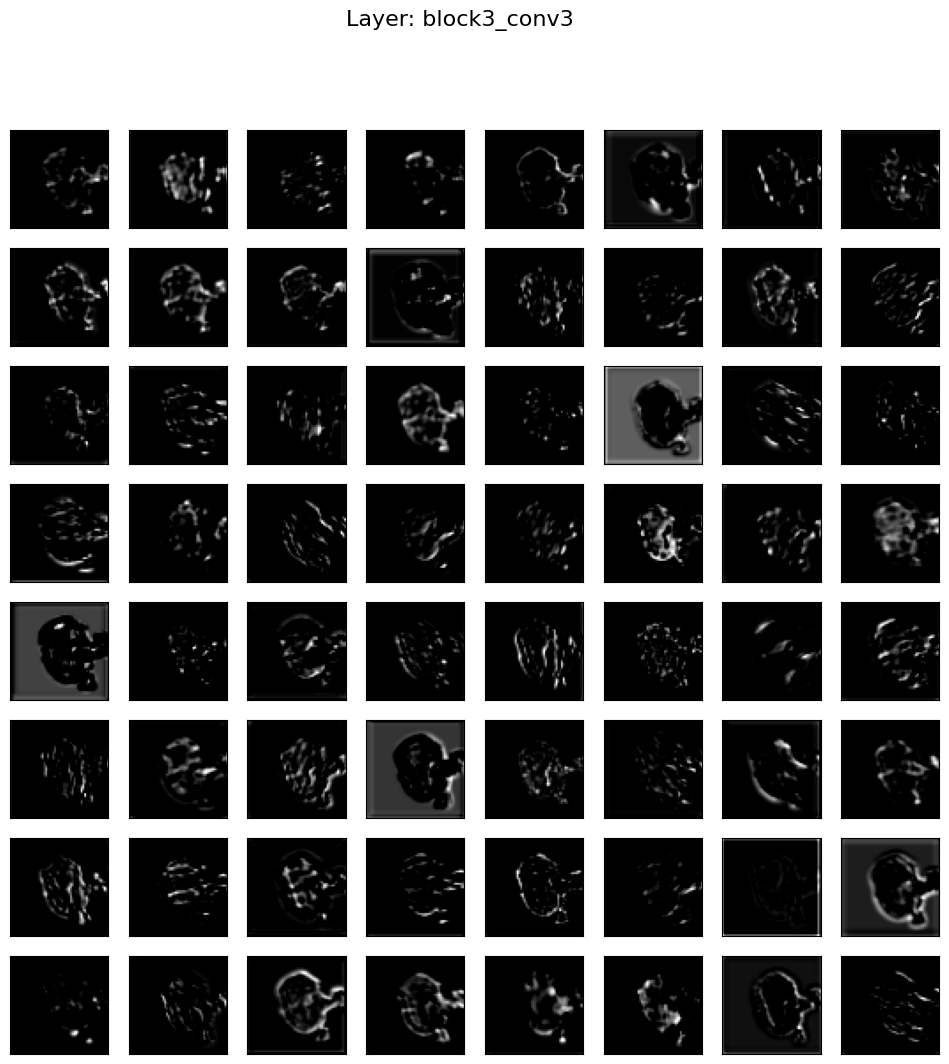

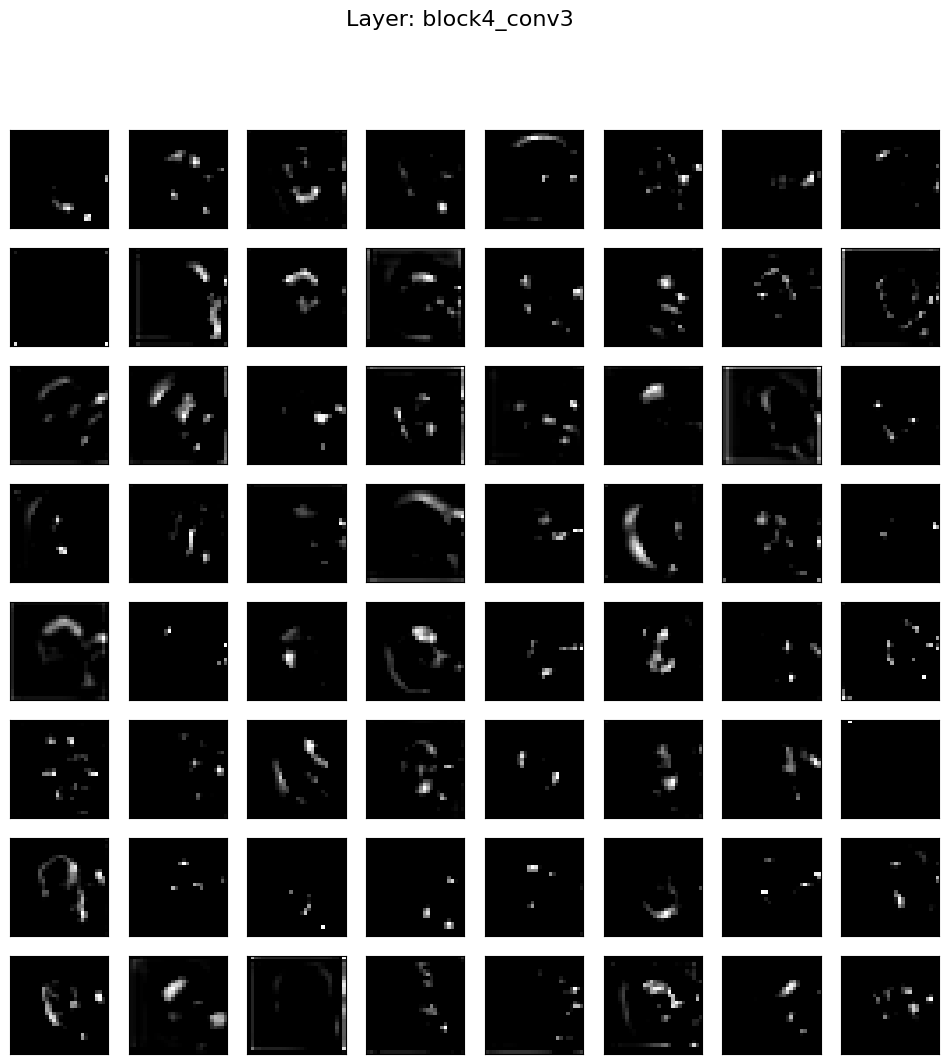

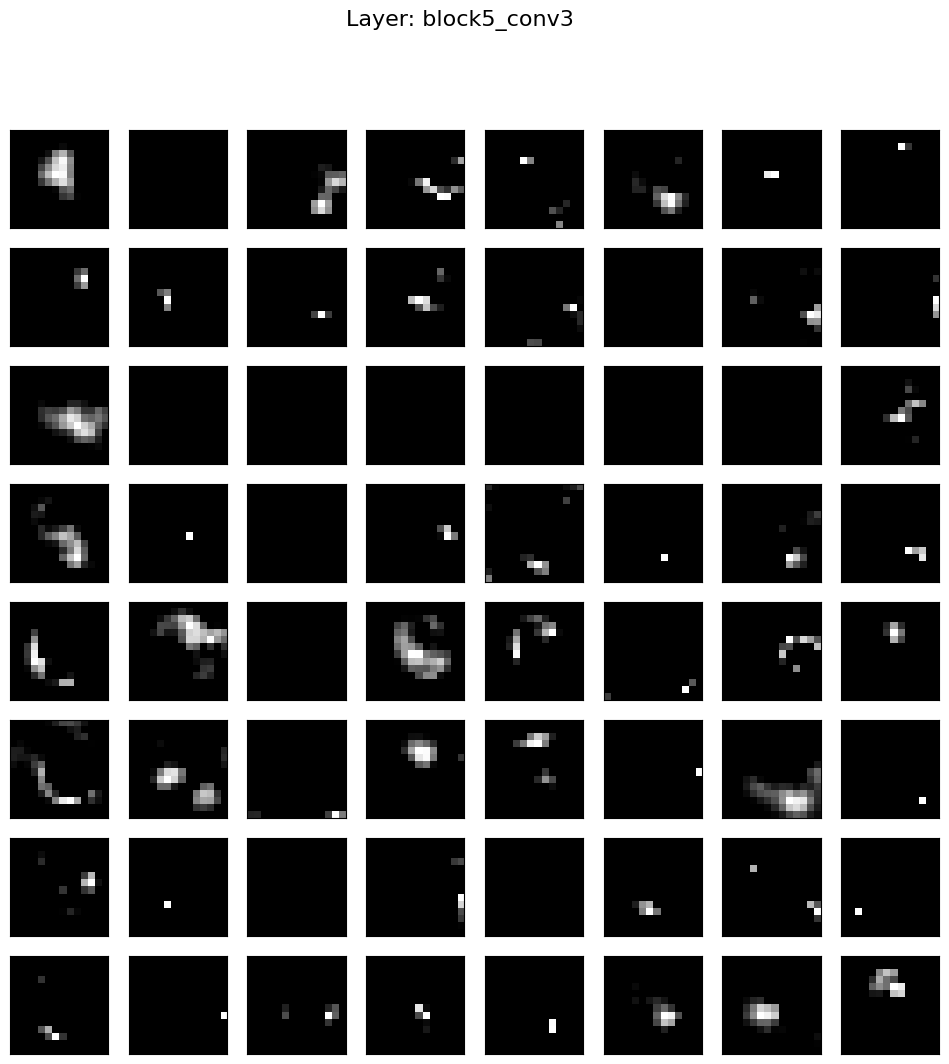

In [ ]:
# Plotting feature maps with layer names
square = 8
for layer, fmap in zip(layers, feature_maps):
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.suptitle(f'Layer: {layer.name}', fontsize=16)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # Specify subplot and turn off axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # Plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix - 1], cmap='gray')
            ix += 1
    plt.show()

#**For Layer 1**

In [ ]:
import pandas as pd
import os

# Load the CSV file
scores_csv_path = '/content/drive/MyDrive/Datasets/Coldsheet.csv'
scores_df = pd.read_csv(scores_csv_path)

# Assuming your CSV has columns 'image_name' and 'score'
image_paths = [os.path.join('/content/drive/MyDrive/Datasets/kidney_refined_img/images new', fname) for fname in scores_df['Name of image']]
labels = scores_df['Score of 1 - 5'].values

In [ ]:
def load_image_with_extension_check(image_path_without_extension):
    # Check for both JPG and PNG extensions
    for extension in ['.jpg', '.png']:
        full_path = f"{image_path_without_extension}{extension}"
        if os.path.exists(full_path):
            return load_img(full_path, target_size=(224, 224))
    # If neither file exists, return None or raise an error
    return None  # Or raise FileNotFoundError(f"No file found for base path {image_path_without_extension}")

processed_features = []  # To store concatenated features of successfully processed images
processed_labels = []  # To store labels for successfully processed images

for img_path, label in zip(image_paths, labels):
    try:
        img = load_image_with_extension_check(img_path)
        if img is not None:
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            feature_maps = feature_model.predict(img)

            # Concatenate the feature maps from all layers into a single feature vector
            features = np.concatenate([np.ravel(fmap) for fmap in feature_maps])

            processed_features.append(features)
            processed_labels.append(label)
        else:
            print(f"Warning: Image not found or failed to load - {img_path}")
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")

# Convert the lists to NumPy arrays if any features were processed
if processed_features:
    X = np.vstack(processed_features)
    y = np.array(processed_labels)

    print(f"Number of feature vectors (X): {len(X)}")
    print(f"Number of labels (y): {len(y)}")
else:
    print("No features were processed.")


1/1 [==============================] - 1s 546ms/step
Number of feature vectors (X): 99
Number of labels (y): 99


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert labels to a numeric format
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Train a classifier for each layer's features
for layer_name, layer_features in features.items():
    X = np.array(layer_features)
    y = numeric_labels

    # Ensure the feature shape is compatible with sklearn models
    n_samples, n_features = X.shape[0], X.shape[1]
    X = X.reshape((n_samples, n_features))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{layer_name} accuracy: {accuracy}")

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [1]:
print(type(features))

NameError: name 'features' is not defined

In [ ]:
print(f"Number of feature vectors (X): {len(X)}")
print(f"Number of labels (y): {len(y)}")


Number of feature vectors (X): 99
Number of labels (y): 100
